In [3]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import os, sys
import logging
import operator
import gc
from sklearn import metrics

/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [8]:
train_trans = pd.read_pickle('train_transaction_15.pkl')
test_trans = pd.read_pickle('test_transaction_15.pkl')
print('train_set shape after merge:',train_trans.shape)
print('test_set shape after merge:',test_trans.shape)

train_set shape after merge: (590540, 765)
test_set shape after merge: (506691, 765)


In [9]:
#drop cols
not_use = ['dist2', 'C3', 'D7', 'M1', 'id_04', 'id_07', 'id_08', 'id_10', 'id_16', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_34', 'id_35']
rm_cols = ['bank_type','uid1','uid2','uid3','uid4','uid5','DT','DT_W','DT_D','DT_hour','DT_day_week','DT_day','DT_D_total','DT_W_total','DT_M_total','id_30','id_31','id_33']
drop_v_vols = ['V1', 'V2', 'V14', 'V15', 'V16', 'V18', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V31', 'V32', 'V39', 'V41', 'V42', 'V43', 'V50', 'V55', 'V57', 'V65', 'V66', 'V67', 'V68', 'V77', 'V79', 'V86', 'V88', 'V89', 'V98', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V141', 'V142', 'V144', 'V148', 'V153', 'V155', 'V157', 'V168', 'V174', 'V179', 'V181', 'V183', 'V185', 'V186', 'V190', 'V191', 'V192', 'V193', 'V194', 'V196', 'V198', 'V199', 'V211', 'V218', 'V230', 'V232', 'V235', 'V236', 'V237', 'V240', 'V241', 'V248', 'V250', 'V252', 'V254', 'V255', 'V260', 'V269', 'V281', 'V284', 'V286', 'V290', 'V293', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V305', 'V309', 'V311', 'V316', 'V318', 'V319', 'V320', 'V321', 'V325', 'V327', 'V328', 'V330', 'V334', 'V337', 'V339']
drop_cols2 = ['had_id','M_sum','D9','V138','D9_not_na','card1','TransactionDTday','card1_TransactionAmt_decimal_min', 'bank_type_TransactionAmt_decimal_min', 'card2_TransactionAmt_decimal_min', 'card5_TransactionAmt_decimal_min', 'card3_TransactionAmt_decimal_min']
#'is_holiday','is_december'
v_toomuchnan = 'V322, V323, V324, V325, V326, V327, V328, V329, V330, V331, V332, V333, V334, V335, V336, V337, V338, V339, V143, V144, V145, V150, V151, V152, V159, V160, V164, V165, V166, V138, V139, V140, V141, V142, V146, V147, V148, V149, V153, V154, V155, V156, V157, V158, V161, V162, V163'
v_toomuchnan = v_toomuchnan.split(', ')
v_low_importance = ['V8', 'V238', 'V335', 'V97', 'V287', 'V329', 'V34', 'V242', 'V33', 'V80', 'V167', 'V175', 'V51', 'V161', 'V226', 'V71', 'V249', 'V336', 'V46', 'V151', 'V158', 'V163', 'V303', 'V177', 'V172', 'V331', 'V326', 'V322', 'V95', 'V9', 'V100', 'V195', 'V173', 'V17', 'V247', 'V92', 'V304', 'V84']
inter_nan_low = [c for c in v_toomuchnan if (c in v_low_importance)]
print(inter_nan_low)

#rfe_not1 = ['card3_fq_enc','bank_type_D1_mean','bank_type_D7_mean','bank_type_D10_mean','bank_type_D11_mean','D6_DT_W_min_max','D7_DT_W_min_max', 'D7_DT_W_std_score', 'D12_DT_W_min_max', 'D13_DT_W_min_max', 'D6_DT_M_min_max', 'D7_DT_M_std_score','D12_DT_M_min_max','D12_DT_M_std_score','D13_DT_M_min_max']

#['bank_type_D1_std','bank_type_D11_std','uid4_D12_std','uid5_D12_std','bank_type_D15_std']
not_use = not_use + rm_cols + drop_cols2 + drop_v_vols 
train_trans = train_trans.drop(not_use,axis=1)
test_trans = test_trans.drop(not_use,axis=1)

['V322', 'V326', 'V329', 'V331', 'V335', 'V336', 'V151', 'V158', 'V161', 'V163']


In [10]:
view=train_trans.columns.values
np.set_printoptions(threshold=np.inf)
print(list(view))

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17', 'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V139', 'V140', 'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V1

In [5]:
D_groups = ['D3_DT_D_min_max', 'D3_DT_D_std_score', 'D4_DT_D_min_max', 'D4_DT_D_std_score', 'D5_DT_D_min_max', 'D5_DT_D_std_score', 'D6_DT_D_min_max', 'D6_DT_D_std_score', 'D7_DT_D_min_max', 'D7_DT_D_std_score', 'D8_DT_D_min_max', 'D8_DT_D_std_score', 'D10_DT_D_min_max', 'D10_DT_D_std_score', 'D11_DT_D_min_max', 'D11_DT_D_std_score', 'D12_DT_D_min_max', 'D12_DT_D_std_score', 'D13_DT_D_min_max', 'D13_DT_D_std_score', 'D14_DT_D_min_max', 'D14_DT_D_std_score', 'D15_DT_D_min_max', 'D15_DT_D_std_score', 'D3_DT_W_min_max', 'D3_DT_W_std_score', 'D4_DT_W_min_max', 'D4_DT_W_std_score', 'D5_DT_W_min_max', 'D5_DT_W_std_score', 'D6_DT_W_min_max', 'D6_DT_W_std_score', 'D7_DT_W_min_max', 'D7_DT_W_std_score', 'D8_DT_W_min_max', 'D8_DT_W_std_score', 'D10_DT_W_min_max', 'D10_DT_W_std_score', 'D11_DT_W_min_max', 'D11_DT_W_std_score', 'D12_DT_W_min_max', 'D12_DT_W_std_score', 'D13_DT_W_min_max', 'D13_DT_W_std_score', 'D14_DT_W_min_max', 'D14_DT_W_std_score', 'D15_DT_W_min_max', 'D15_DT_W_std_score', 'D3_DT_M_min_max', 'D3_DT_M_std_score', 'D4_DT_M_min_max', 'D4_DT_M_std_score', 'D5_DT_M_min_max', 'D5_DT_M_std_score', 'D6_DT_M_min_max', 'D6_DT_M_std_score', 'D7_DT_M_min_max', 'D7_DT_M_std_score', 'D8_DT_M_min_max', 'D8_DT_M_std_score', 'D10_DT_M_min_max', 'D10_DT_M_std_score', 'D11_DT_M_min_max', 'D11_DT_M_std_score', 'D12_DT_M_min_max', 'D12_DT_M_std_score', 'D13_DT_M_min_max', 'D13_DT_M_std_score', 'D14_DT_M_min_max', 'D14_DT_M_std_score', 'D15_DT_M_min_max', 'D15_DT_M_std_score']
#'productCD_sep', 'uid1_D1_minusday_mean', 'uid1_D1_minusday_min', 'uid2_D1_minusday_mean', 'uid2_D1_minusday_min', 'uid3_D1_minusday_mean', 'uid3_D1_minusday_min', 'uid4_D1_minusday_mean', 'uid4_D1_minusday_min', 'uid5_D1_minusday_mean', 'uid5_D1_minusday_min', 'bank_type_D1_minusday_mean', 'bank_type_D1_minusday_min', 'uid1_D2_minusday_mean', 'uid1_D2_minusday_min', 'uid2_D2_minusday_mean', 'uid2_D2_minusday_min', 'uid3_D2_minusday_mean', 'uid3_D2_minusday_min', 'uid4_D2_minusday_mean', 'uid4_D2_minusday_min', 'uid5_D2_minusday_mean', 'uid5_D2_minusday_min', 'bank_type_D2_minusday_mean', 'bank_type_D2_minusday_min', 'uid1_D4_minusday_mean', 'uid1_D4_minusday_min', 'uid2_D4_minusday_mean', 'uid2_D4_minusday_min', 'uid3_D4_minusday_mean', 'uid3_D4_minusday_min', 'uid4_D4_minusday_mean', 'uid4_D4_minusday_min', 'uid5_D4_minusday_mean', 'uid5_D4_minusday_min', 'bank_type_D4_minusday_mean', 'bank_type_D4_minusday_min', 'uid1_D5_minusday_mean', 'uid1_D5_minusday_min', 'uid2_D5_minusday_mean', 'uid2_D5_minusday_min', 'uid3_D5_minusday_mean', 'uid3_D5_minusday_min', 'uid4_D5_minusday_mean', 'uid4_D5_minusday_min', 'uid5_D5_minusday_mean', 'uid5_D5_minusday_min', 'bank_type_D5_minusday_mean', 'bank_type_D5_minusday_min', 'uid1_D8_minusday_mean', 'uid1_D8_minusday_min', 'uid2_D8_minusday_mean', 'uid2_D8_minusday_min', 'uid3_D8_minusday_mean', 'uid3_D8_minusday_min', 'uid4_D8_minusday_mean', 'uid4_D8_minusday_min', 'uid5_D8_minusday_mean', 'uid5_D8_minusday_min', 'bank_type_D8_minusday_mean', 'bank_type_D8_minusday_min', 'uid1_D10_minusday_mean', 'uid1_D10_minusday_min', 'uid2_D10_minusday_mean', 'uid2_D10_minusday_min', 'uid3_D10_minusday_mean', 'uid3_D10_minusday_min', 'uid4_D10_minusday_mean', 'uid4_D10_minusday_min', 'uid5_D10_minusday_mean', 'uid5_D10_minusday_min', 'bank_type_D10_minusday_mean', 'bank_type_D10_minusday_min', 'uid1_D11_minusday_mean', 'uid1_D11_minusday_min', 'uid2_D11_minusday_mean', 'uid2_D11_minusday_min', 'uid3_D11_minusday_mean', 'uid3_D11_minusday_min', 'uid4_D11_minusday_mean', 'uid4_D11_minusday_min', 'uid5_D11_minusday_mean', 'uid5_D11_minusday_min', 'bank_type_D11_minusday_mean', 'bank_type_D11_minusday_min', 'uid1_D15_minusday_mean', 'uid1_D15_minusday_min', 'uid2_D15_minusday_mean', 'uid2_D15_minusday_min', 'uid3_D15_minusday_mean', 'uid3_D15_minusday_min', 'uid4_D15_minusday_mean', 'uid4_D15_minusday_min', 'uid5_D15_minusday_mean', 'uid5_D15_minusday_min', 'bank_type_D15_minusday_mean', 'bank_type_D15_minusday_min', 'uid1_D3_mean', 'uid1_D3_min', 'uid2_D3_mean', 'uid2_D3_min', 'uid3_D3_mean', 'uid3_D3_min', 'uid4_D3_mean', 'uid4_D3_min', 'uid5_D3_mean', 'uid5_D3_min', 'bank_type_D3_mean', 'bank_type_D3_min', 'uid1_D6_mean', 'uid1_D6_min', 'uid2_D6_mean', 'uid2_D6_min', 'uid3_D6_mean', 'uid3_D6_min', 'uid4_D6_mean', 'uid4_D6_min', 'uid5_D6_mean', 'uid5_D6_min', 'bank_type_D6_mean', 'bank_type_D6_min', 'uid1_D7_mean', 'uid1_D7_min', 'uid2_D7_mean', 'uid2_D7_min', 'uid3_D7_mean', 'uid3_D7_min', 'uid4_D7_mean', 'uid4_D7_min', 'uid5_D7_mean', 'uid5_D7_min', 'bank_type_D7_mean', 'bank_type_D7_min', 'uid1_D9_mean', 'uid1_D9_min', 'uid2_D9_mean', 'uid2_D9_min', 'uid3_D9_mean', 'uid3_D9_min', 'uid4_D9_mean', 'uid4_D9_min', 'uid5_D9_mean', 'uid5_D9_min', 'bank_type_D9_mean', 'bank_type_D9_min', 'uid1_D12_mean', 'uid1_D12_min', 'uid2_D12_mean', 'uid2_D12_min', 'uid3_D12_mean', 'uid3_D12_min', 'uid4_D12_mean', 'uid4_D12_min', 'uid5_D12_mean', 'uid5_D12_min', 'bank_type_D12_mean', 'bank_type_D12_min', 'uid1_D13_mean', 'uid1_D13_min', 'uid2_D13_mean', 'uid2_D13_min', 'uid3_D13_mean', 'uid3_D13_min', 'uid4_D13_mean', 'uid4_D13_min', 'uid5_D13_mean', 'uid5_D13_min', 'bank_type_D13_mean', 'bank_type_D13_min', 'uid1_D14_mean', 'uid1_D14_min', 'uid2_D14_mean', 'uid2_D14_min', 'uid3_D14_mean', 'uid3_D14_min', 'uid4_D14_mean', 'uid4_D14_min', 'uid5_D14_mean', 'uid5_D14_min', 'bank_type_D14_mean', 'bank_type_D14_min', 'D8_not_same_day', 'D8_D9_decimal_dist',
C_news = ['uid2_C1_mean','uid2_C1_std','uid3_C1_mean','uid3_C1_std','uid4_C1_mean',
 'uid4_C1_std','uid5_C1_mean','uid5_C1_std','bank_type_C1_mean',
 'bank_type_C1_std','uid1_C2_mean','uid1_C2_std','uid2_C2_mean',
 'uid2_C2_std','uid3_C2_mean','uid3_C2_std','uid4_C2_mean','uid4_C2_std',
 'uid5_C2_mean','uid5_C2_std','bank_type_C2_mean','bank_type_C2_std',
 'uid1_C4_mean','uid1_C4_std','uid2_C4_mean','uid2_C4_std','uid3_C4_mean',
 'uid3_C4_std','uid4_C4_mean','uid4_C4_std','uid5_C4_mean','uid5_C4_std',
 'bank_type_C4_mean','bank_type_C4_std','uid1_C6_mean','uid1_C6_std',
 'uid2_C6_mean','uid2_C6_std','uid3_C6_mean','uid3_C6_std','uid4_C6_mean',
 'uid4_C6_std','uid5_C6_mean','uid5_C6_std','bank_type_C6_mean',
 'bank_type_C6_std','uid1_C7_mean','uid1_C7_std','uid2_C7_mean',
 'uid2_C7_std','uid3_C7_mean','uid3_C7_std','uid4_C7_mean','uid4_C7_std',
 'uid5_C7_mean','uid5_C7_std','bank_type_C7_mean','bank_type_C7_std',
 'uid1_C11_mean','uid1_C11_std','uid2_C11_mean','uid2_C11_std',
 'uid3_C11_mean','uid3_C11_std','uid4_C11_mean','uid4_C11_std',
 'uid5_C11_mean','uid5_C11_std','bank_type_C11_mean','bank_type_C11_std',
 'uid1_C12_mean','uid1_C12_std','uid2_C12_mean','uid2_C12_std',
 'uid3_C12_mean','uid3_C12_std','uid4_C12_mean','uid4_C12_std',
 'uid5_C12_mean','uid5_C12_std','bank_type_C12_mean','bank_type_C12_std',
 'uid1_C14_mean','uid1_C14_std','uid2_C14_mean','uid2_C14_std',
 'uid3_C14_mean', 'uid3_C14_std','uid4_C14_mean','uid4_C14_std',
 'uid5_C14_mean','uid5_C14_std','bank_type_C14_mean','bank_type_C14_std']
v_news = ['V144_uid3_diff1','V145_uid3_diff1','V150_uid3_diff1',
 'V159_uid3_diff1', 'V160_uid3_diff1', 'V144_uid4_diff1', 'V145_uid4_diff1',
 'V150_uid4_diff1', 'V159_uid4_diff1', 'V160_uid4_diff1' ,'V126_uid3_diff1',
 'V127_uid3_diff1', 'V128_uid3_diff1', 'V129_uid3_diff1', 'V130_uid3_diff1',
 'V131_uid3_diff1', 'V132_uid3_diff1', 'V133_uid3_diff1', 'V134_uid3_diff1',
 'V135_uid3_diff1', 'V136_uid3_diff1', 'V137_uid3_diff1', 'V126_uid4_diff1',
 'V127_uid4_diff1', 'V128_uid4_diff1', 'V129_uid4_diff1', 'V130_uid4_diff1',
 'V131_uid4_diff1', 'V132_uid4_diff1', 'V133_uid4_diff1', 'V134_uid4_diff1',
 'V135_uid4_diff1', 'V136_uid4_diff1', 'V137_uid4_diff1']
not_use2 = D_groups
#train_trans = train_trans.drop(not_use2,axis=1)
#test_trans = test_trans.drop(not_use2,axis=1)

In [6]:
# date_eda_match
# Let's try Christmas month 
# but take 1 day before as our TransactionDT starts with 1 day (86400s)
'''
import os, sys, random, datetime
START_DATE = '2017-11-30'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
train_trans['DT_M'] = train_trans['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test_trans['DT_M'] = test_trans['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
train_trans['DT_M'] = (train_trans['DT_M'].dt.year-2017)*12 + train_trans['DT_M'].dt.month 
test_trans['DT_M'] = (test_trans['DT_M'].dt.year-2017)*12 + test_trans['DT_M'].dt.month 
'''

"\nimport os, sys, random, datetime\nSTART_DATE = '2017-11-30'\nstartdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')\ntrain_trans['DT_M'] = train_trans['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))\ntest_trans['DT_M'] = test_trans['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))\ntrain_trans['DT_M'] = (train_trans['DT_M'].dt.year-2017)*12 + train_trans['DT_M'].dt.month \ntest_trans['DT_M'] = (test_trans['DT_M'].dt.year-2017)*12 + test_trans['DT_M'].dt.month \n"

In [11]:
from sklearn.preprocessing import LabelEncoder
for col in train_trans.columns:
    if train_trans[col].dtype == 'object':
        print(col)
        le = LabelEncoder()
        le.fit(list(train_trans[col].astype(str).values) + list(test_trans[col].astype(str).values))
        train_trans[col] = le.transform(list(train_trans[col].astype(str).values))
        test_trans[col] = le.transform(list(test_trans[col].astype(str).values))

P_emaildomain_bin
P_emaildomain_suffix
P_emaildomain_prefix
P_emaildomain_suffix_us
R_emaildomain_bin
R_emaildomain_suffix
R_emaildomain_prefix
R_emaildomain_suffix_us
uid6
cid_1
uid7
DeviceType
DeviceInfo
device_name
device_version
OS_id_30
version_id_30
browser_id_31
version_id_31
screen_width
screen_height


In [12]:
#fit_lgb
X = train_trans.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT','TransactionID'], axis=1)
y = train_trans.sort_values('TransactionDT')['isFraud']
X_test = test_trans.drop(['TransactionDT', 'isFraud','TransactionID'], axis=1)
print('the shape of train_df is:',X.shape)
print('the shape of test_df is:',X_test.shape)

the shape of train_df is: (590540, 580)
the shape of test_df is: (506691, 580)


In [13]:
#fit_lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
NFOLDS = 6
folds = GroupKFold(n_splits=NFOLDS)

params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'num_threads':4,
          'n_estimators':1800
         }

columns = X.columns
split_groups = X['DT_M']    
splits = folds.split(X, y,groups=split_groups)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n)
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=200)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")


Fold: 0


/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.971453	valid_1's auc: 0.891184
[400]	training's auc: 0.989455	valid_1's auc: 0.904031
[600]	training's auc: 0.99706	valid_1's auc: 0.909889
[800]	training's auc: 0.999393	valid_1's auc: 0.913625
[1000]	training's auc: 0.999888	valid_1's auc: 0.915455
[1200]	training's auc: 0.999982	valid_1's auc: 0.916168
[1400]	training's auc: 0.999998	valid_1's auc: 0.916865
[1600]	training's auc: 1	valid_1's auc: 0.917272
[1800]	training's auc: 1	valid_1's auc: 0.917795
Did not meet early stopping. Best iteration is:
[1800]	training's auc: 1	valid_1's auc: 0.917795
Fold 1 | AUC: 0.9177953936625561
Fold: 1


/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.96969	valid_1's auc: 0.920822
[400]	training's auc: 0.988761	valid_1's auc: 0.934166
[600]	training's auc: 0.996854	valid_1's auc: 0.941576
[800]	training's auc: 0.999323	valid_1's auc: 0.944672
[1000]	training's auc: 0.999881	valid_1's auc: 0.946245
[1200]	training's auc: 0.999982	valid_1's auc: 0.947325
[1400]	training's auc: 0.999998	valid_1's auc: 0.948036
[1600]	training's auc: 1	valid_1's auc: 0.948581
[1800]	training's auc: 1	valid_1's auc: 0.948872
Did not meet early stopping. Best iteration is:
[1800]	training's auc: 1	valid_1's auc: 0.948872
Fold 2 | AUC: 0.9488720057297425
Fold: 2


/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.96826	valid_1's auc: 0.920554
[400]	training's auc: 0.987827	valid_1's auc: 0.935602
[600]	training's auc: 0.996466	valid_1's auc: 0.943443
[800]	training's auc: 0.999221	valid_1's auc: 0.947088
[1000]	training's auc: 0.999852	valid_1's auc: 0.949156
[1200]	training's auc: 0.999977	valid_1's auc: 0.950193
[1400]	training's auc: 0.999998	valid_1's auc: 0.95117
[1600]	training's auc: 1	valid_1's auc: 0.951844
[1800]	training's auc: 1	valid_1's auc: 0.952238
Did not meet early stopping. Best iteration is:
[1800]	training's auc: 1	valid_1's auc: 0.952238
Fold 3 | AUC: 0.9522384455044696
Fold: 3


/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.969039	valid_1's auc: 0.918642
[400]	training's auc: 0.988276	valid_1's auc: 0.932674
[600]	training's auc: 0.996489	valid_1's auc: 0.939935
[800]	training's auc: 0.999203	valid_1's auc: 0.942815
[1000]	training's auc: 0.999846	valid_1's auc: 0.94415
[1200]	training's auc: 0.999974	valid_1's auc: 0.945143
[1400]	training's auc: 0.999997	valid_1's auc: 0.945986
[1600]	training's auc: 1	valid_1's auc: 0.946412
[1800]	training's auc: 1	valid_1's auc: 0.946528
Did not meet early stopping. Best iteration is:
[1800]	training's auc: 1	valid_1's auc: 0.946528
Fold 4 | AUC: 0.9465279738933354
Fold: 4


/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.968428	valid_1's auc: 0.933777
[400]	training's auc: 0.988041	valid_1's auc: 0.945386
[600]	training's auc: 0.996384	valid_1's auc: 0.950675
[800]	training's auc: 0.999151	valid_1's auc: 0.952507
[1000]	training's auc: 0.99983	valid_1's auc: 0.953559
[1200]	training's auc: 0.999972	valid_1's auc: 0.954101
[1400]	training's auc: 0.999997	valid_1's auc: 0.954514
[1600]	training's auc: 1	valid_1's auc: 0.954809
[1800]	training's auc: 1	valid_1's auc: 0.955132
Did not meet early stopping. Best iteration is:
[1800]	training's auc: 1	valid_1's auc: 0.955132
Fold 5 | AUC: 0.9551321001631795
Fold: 5


/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.967833	valid_1's auc: 0.925596
[400]	training's auc: 0.98734	valid_1's auc: 0.943839
[600]	training's auc: 0.996104	valid_1's auc: 0.951789
[800]	training's auc: 0.999057	valid_1's auc: 0.954907
[1000]	training's auc: 0.999806	valid_1's auc: 0.956801
[1200]	training's auc: 0.999966	valid_1's auc: 0.957926
[1400]	training's auc: 0.999995	valid_1's auc: 0.958768
[1600]	training's auc: 1	valid_1's auc: 0.959272
[1800]	training's auc: 1	valid_1's auc: 0.959614
Did not meet early stopping. Best iteration is:
[1800]	training's auc: 1	valid_1's auc: 0.959614
Fold 6 | AUC: 0.9596144534096599

Mean AUC = 0.9466967287271573
Out of folds AUC = 0.9459541011690419


In [10]:
#prediction
submission = pd.DataFrame({'TransactionID':test_trans['TransactionID'],'isFraud':y_preds})
print('submission_shape is:',submission.shape)

submission_shape is: (506691, 2)


In [11]:
submission.to_csv('submission_16.4.csv',index = False)

In [12]:
submission.head()

,TransactionID,isFraud
0,3663549,0.000290
1,3663550,0.001005
2,3663551,0.003504
3,3663552,0.001112
4,3663553,0.000556


NameError: name 'folds' is not defined

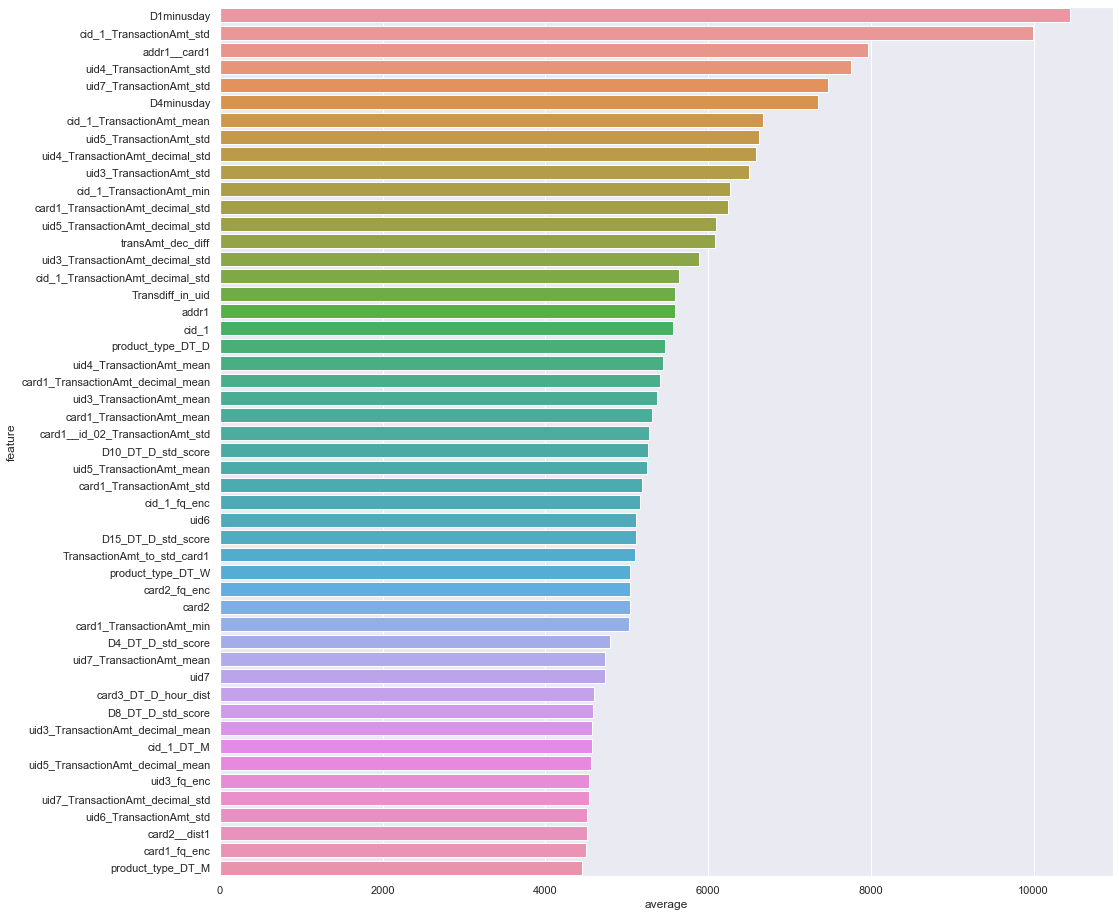

In [4]:
#feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances = pd.read_csv('feature_importances_16.4.csv')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [14]:
ft_imp04 = feature_importances
ft_imp04 = ft_imp04.sort_values(by = 'average', axis=0, ascending=False).reset_index()
#ft_imp04[ft_imp04['feature']=='browser_id_31'].index
ft_imp04.tail(50)

,index,feature,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,average
552,182,V227,38,59,70,86,41,67,60.166667
553,63,V34,58,52,80,68,54,48,60.000000
554,198,V253,45,71,60,56,42,76,58.333333
555,194,V246,69,48,52,64,58,52,57.166667
556,89,V71,64,45,74,58,43,54,56.333333
557,183,V228,79,51,46,51,43,58,54.666667
558,506,ica_V327,32,45,63,49,69,51,51.500000
559,143,V172,44,69,50,56,27,61,51.166667
560,181,V226,57,68,17,58,41,60,50.166667
561,147,V177,64,40,49,46,31,65,49.166667


'V126' 'V127' 'V128' 'V130' 'V131' 'V132' 'V133' 'V134' 'V136' 'V137'
 'V143' 'V144' 'V145' 'V150' 'V159' 'V160' 'V164' 'V165' 'V166' 'V202'
 'V203' 'V204' 'V205' 'V206' 'V207' 'V208' 'V209' 'V210' 'V211' 'V212'
 'V213' 'V214' 'V215' 'V216' 'V263' 'V264' 'V265' 'V266' 'V267' 'V268'
 'V270' 'V271' 'V272' 'V273' 'V274' 'V275' 'V276' 'V277' 'V278' 'V306'
 'V307' 'V308' 'V309' 'V310' 'V312' 'V313' 'V314' 'V315' 'V316' 'V317'
 'V318' 'V320' 'V321' 'V331' 'V332' 'V333' 'V335'

In [15]:
ft_imp03 = pd.read_csv('feature_importances.csv',nrows = None)
ft_imp03 = ft_imp03.sort_values(by = 'average', axis=0, ascending=False)
ft_imp03.tail(20)

,Unnamed: 0,feature,fold_1,fold_2,fold_3,fold_4,fold_5,average
93,93,V41,5,4,7,5,7,5.6
66,66,V14,9,8,2,6,3,5.6
377,377,V325,4,4,9,4,2,4.6
170,170,V118,11,2,3,2,0,3.6
418,418,id_27,1,0,2,4,2,1.8
174,174,V122,2,3,2,0,2,1.8
117,117,V65,2,3,1,0,0,1.2
79,79,V27,2,1,2,1,0,1.2
442,442,had_id,1,0,3,1,0,1.0
140,140,V88,1,0,1,0,2,0.8


In [16]:
1144706017592

1144706017592